In [18]:
%pylab inline
import seaborn as sns
import numpy as np
import pandas as pd
import cPickle as pickle
from irm import cvpipelineutil
import sklearn.neighbors
import scipy.sparse
import irm
sns.set_style('whitegrid')
import os
import sys
sys.path.append("../")


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
seed = 0
td = lambda x : os.path.join("../data/", x)
infile = td("mushroombody.KC-MBON.rosette.df.pickle")
mbon_name = "MBON-14-B"


neurons_data = pickle.load(open(td("mushroombody.neurondf.pickle"), 'r'))
synapse_data = pickle.load(open(td("mushroombody.synapsesdf.pickle"), 'r'))
basicmat_data = pickle.load(open(td("mushroombody.cleandata.pickle"), 'r'))
kc_mbon_rosettes = pickle.load(open(infile, 'r'))
rosette_df = kc_mbon_rosettes['rosette_df']
tbar_df = synapse_data['tbar_df']
connections_df = synapse_data['connections_df']
neurons_df = neurons_data['neurondf']

d = pickle.load(open(td("mushroombody.KC-rosette-KC.mats.pickle"), 'r'))

a = d['all_results'][(20, True)]
kc_kc_mats = a['kc_kc_mats']
kc_rosette_kc_mats = a['kc_rosette_kc_mats']
pre_ids_names_sorted = d['pre_ids_names_sorted']
pre_ids_to_pos = d['pre_ids_to_pos']

sort_order = d['sort_order']
KCN = len(sort_order)
ITERS = 1000


['KC-alpha prime', 'KC-p', 'KC-s', 'KC-c', 'KC-any']

In [7]:
cell_types = ['KC-alpha prime', 'KC-p', 'KC-s', 'KC-c', 'KC-any']
# somewhat of a PITA load process
per_type_chains = {}
per_type_meta = {}
for i in range(10):
    sfile = td("KC-rosette-KC.per_type.%s.samples.%02d.pickle" % (mbon_name, i))      
    a = pickle.load(open(sfile, 'r'))
    per_type_samples = a['samples']
    for cell_type_tgt in cell_types:
        sample = per_type_samples[cell_type_tgt]
        conmat_sub = sample['conmat_sub']
        mat_ids_order =sample['mat_ids_order']
        res = sample['res']
        if cell_type_tgt not in per_type_chains:
            per_type_chains[cell_type_tgt] = []
            per_type_meta[cell_type_tgt] = []
            
        per_type_chains[cell_type_tgt].append(res[1])
        per_type_meta[cell_type_tgt].append({'conmat_sub' : conmat_sub, 'mat_ids_order': mat_ids_order})


In [8]:
per_type_chains.keys()

['KC-s', 'KC-c', 'KC-p', 'KC-alpha prime', 'KC-any']

In [ ]:
tgt_type = 'KC-s'
sample_pos = 0

rosette_mat = kc_rosette_kc_mats[mbon_name]
conn_mat = conmat_sub = per_type_meta[tgt_type][sample_pos]['conmat_sub']
chains = per_type_chains[tgt_type]

assignment = irm.util.canonicalize_assignment(chains[sample_pos]['domains']['d1']['assignment'])
sort_order = np.argsort(assignment.flatten())

fig = pylab.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)

conn_sorted = conn_mat[sort_order]
conn_sorted = conn_sorted[:, sort_order]
KCN = conn_mat.shape[0]

a = np.argwhere(conn_sorted)
print len(a)
counts = np.array([conn_sorted[i, j] for i, j in a])
ax.scatter(a[:, 0], a[:, 1], edgecolor='none', c='k',
           s=15, #s=10*counts**2, 
           alpha=1)
ax.set_xlim(0, KCN)
ax.set_ylim(KCN, 0)

divisions = np.argwhere(np.diff(assignment[sort_order])).flatten()
for d in divisions:
    ax.axhline(d, c='b', alpha=0.1)
    ax.axvline(d, c='b', alpha=0.1)
    

ticks = np.arange(0, KCN, 8)
ax.set_yticks(ticks)
#ax.set_yticklabels(labels_ordered[ticks])
ax.set_xticks(ticks)
#ax.set_xticklabels(labels_ordered[ticks], rotation=90)
#ax.set_yticks([])
ax.set_title(mbon_name)
ax.grid(False)
ax.set_xlabel("kenyon cell ID")
ax.set_ylabel("kenyon cell ID")
#fig.savefig('kc-rosette-kc.%s.%d.pdf' % (tgt_cell, sample_pos))

9040


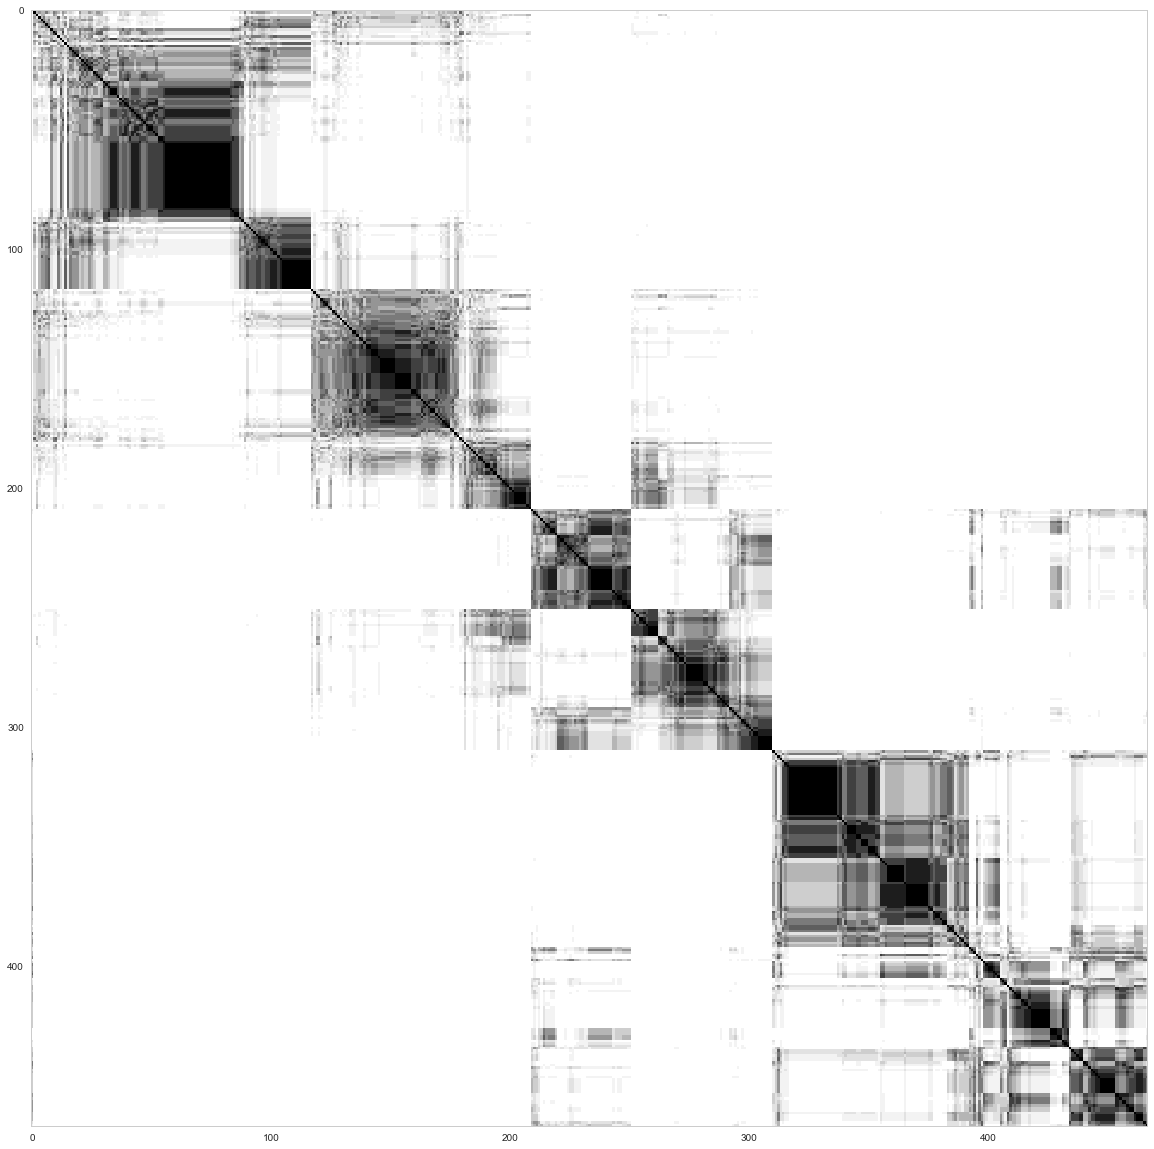

In [15]:

av = [np.array(d['domains']['d1']['assignment']) for d in chains]
z = irm.util.compute_zmatrix(av)    
fig = pylab.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
order = irm.plot.plot_zmatrix(ax, z)
#pre_ids_sorted = [pos_to_pre_ids[s] for s in order]
#labels_ordered = np.array([get_by_pre_id(id)['name'] for id in pre_ids_sorted])

#ticks = np.arange(0, KCN, 8)
#ax.set_yticks(ticks)
#ax.set_yticklabels(labels_ordered[ticks])
#ax.set_xticks(ticks)
#ax.set_xticklabels(labels_ordered[ticks], rotation=90)

ax.grid(False)


In [25]:
def chains_to_assignment_mat(chains):
    
    all_assign = []
    for state in chains:
        ass = state['domains']['d1']['assignment']
        all_assign.append(ass)
    assignments = np.array(all_assign)
    return assignments

In [27]:
import exputil
reload(exputil)
statsdf = []
for tgt_type in cell_types:
    chains = per_type_chains[tgt_type]
    assignments = chains_to_assignment_mat(chains)
    stats = exputil.compute_cluster_stats(assignments)
    stats['tgt_type'] = tgt_type
    statsdf.append(stats)
statsdf= pd.concat(statsdf)

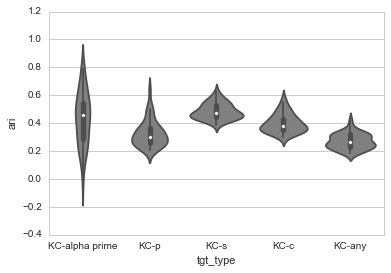

In [44]:
sns.violinplot(x='tgt_type', y='ari', data=statsdf,color='grey')